<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Final-Data-Engineering" data-toc-modified-id="1.-Final-Data-Engineering-1">1. Final Data Engineering</a></span><ul class="toc-item"><li><span><a href="#1.1-Feature-Scaling" data-toc-modified-id="1.1-Feature-Scaling-1.1">1.1 Feature Scaling</a></span></li><li><span><a href="#1.2-SMOTE" data-toc-modified-id="1.2-SMOTE-1.2">1.2 SMOTE</a></span></li><li><span><a href="#1.3-Convert-dataframe" data-toc-modified-id="1.3-Convert-dataframe-1.3">1.3 Convert dataframe</a></span></li></ul></li><li><span><a href="#2.-Model(With-outliers)" data-toc-modified-id="2.-Model(With-outliers)-2">2. Model(With outliers)</a></span><ul class="toc-item"><li><span><a href="#2.1-Define-the-Model" data-toc-modified-id="2.1-Define-the-Model-2.1">2.1 Define the Model</a></span></li><li><span><a href="#2.2-Train-the-model(No-SMOTE)" data-toc-modified-id="2.2-Train-the-model(No-SMOTE)-2.2">2.2 Train the model(No SMOTE)</a></span></li><li><span><a href="#2.3-Train-the-model(SMOTE)" data-toc-modified-id="2.3-Train-the-model(SMOTE)-2.3">2.3 Train the model(SMOTE)</a></span></li><li><span><a href="#2.3-Train-the-model(SMOTE)" data-toc-modified-id="2.3-Train-the-model(SMOTE)-2.4">2.3 Train the model(SMOTE)</a></span></li></ul></li><li><span><a href="#3.-Model(No-Outliers)" data-toc-modified-id="3.-Model(No-Outliers)-3">3. Model(No Outliers)</a></span><ul class="toc-item"><li><span><a href="#3.1-Define-the-Model" data-toc-modified-id="3.1-Define-the-Model-3.1">3.1 Define the Model</a></span></li><li><span><a href="#3.2-Train-the-Model(No-SMOTE)" data-toc-modified-id="3.2-Train-the-Model(No-SMOTE)-3.2">3.2 Train the Model(No SMOTE)</a></span></li><li><span><a href="#3.3-Train-the-Model(SMOTE)" data-toc-modified-id="3.3-Train-the-Model(SMOTE)-3.3">3.3 Train the Model(SMOTE)</a></span></li><li><span><a href="#4.1-Define-the-model" data-toc-modified-id="4.1-Define-the-model-3.4">4.1 Define the model</a></span></li><li><span><a href="#4.2-Train-the-model" data-toc-modified-id="4.2-Train-the-model-3.5">4.2 Train the model</a></span></li><li><span><a href="#4.3-SMOTE" data-toc-modified-id="4.3-SMOTE-3.6">4.3 SMOTE</a></span></li><li><span><a href="#4.3-SMOTE" data-toc-modified-id="4.3-SMOTE-3.7">4.3 SMOTE</a></span></li></ul></li></ul></div>

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt

## 1. Final Data Engineering

In [ ]:
# df_train = pd.read_pickle('../Data/part2_df_train_outliers.pkl')
# df_test = pd.read_pickle('../Data/part2_df_test_outliers.pkl')

df_train = pd.read_pickle('../Data/df_train_with_outliers.pkl')
df_test = pd.read_pickle('../Data/df_test_with_outliers.pkl')

In [ ]:
X_train = df_train.drop(['loan_status'], axis=1)
y_train = df_train.loc[:, 'loan_status']

X_test = df_test.drop(['loan_status'], axis=1)
y_test = df_test['loan_status']

### 1.2 SMOTE

In [ ]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

### 1.3 Convert dataframe

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

## 2. Model(With outliers)

### 2.1 Define the Model

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [ ]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model


### 2.2 Train the model(No SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_no_smote_outliers');

In [ ]:
Y_onehot[1].ravel()

In [ ]:
y_pred[1].ravel()

In [ ]:
plt.figure(figsize=(10, 10))
# plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()[:, 0]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)

lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='DNN (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
# plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show();

In [ ]:
plt.figure(figsize=(10, 10))
# plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()[:, 0]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)

lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='DNN (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
# plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show();

In [ ]:
lr_probs = logreg.predict_proba(X_test)
lr_probs = lr_probs[:, 0]
# predict class values
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.2f auc=%.2f' % (lr_f1, lr_auc))



plt.figure(figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show()

In [ ]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [ ]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

### 2.3 Train the model(SMOTE)

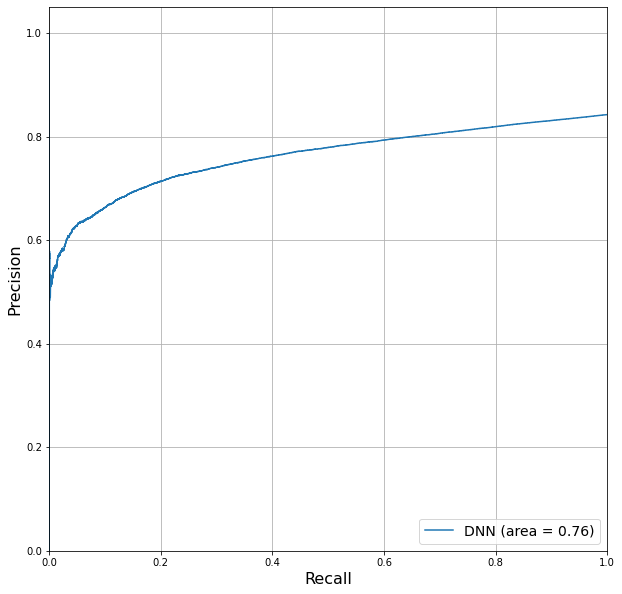

In [12]:
plt.figure(figsize=(10, 10))
# plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()[:, 0]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)

lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='DNN (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
# plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show();

In [ ]:
lr_probs = logreg.predict_proba(X_test)
lr_probs = lr_probs[:, 0]
# predict class values
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.2f auc=%.2f' % (lr_f1, lr_auc))



plt.figure(figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression (area = %0.2f)' % lr_auc)
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/log_prauc_outliers_no_smote')
plt.show()

In [13]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

NameError: name 'Y_PREDICT' is not defined

### 2.3 Train the model(SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_smote_outliers');

In [ ]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [ ]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

## 3. Model(No Outliers)

### 3.1 Define the Model

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [ ]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model

### 3.2 Train the Model(No SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_no_smote_no_outliers');

In [ ]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [ ]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

### 3.3 Train the Model(SMOTE)

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_smote_no_outliers');

In [ ]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [ ]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

In [ ]:
## 4. No Date(Shuffle)

### 4.1 Define the model

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [ ]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model

### 4.2 Train the model

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_no_date');

In [ ]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [ ]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

### 4.3 SMOTE

In [ ]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [ ]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model

In [ ]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_no_date');

In [11]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

tensor([[160618,      0],
        [ 46414,      0]])

### 4.3 SMOTE

In [9]:
sm = SMOTE(random_state=12, n_jobs = -1, k_neighbors=5, sampling_strategy='auto')
X_train, y_train = sm.fit_resample(X_train, y_train)

In [6]:
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 200)
        self.layer2 = nn.Linear(200, 300)
        self.layer3 = nn.Linear(300, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x 

In [7]:
model =  TabularModel(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model

TabularModel(
  (layer1): Linear(in_features=118, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=300, bias=True)
  (layer3): Linear(in_features=300, out_features=2, bias=True)
)

In [8]:
EPOCHS  = 100

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [05:59<00:00,  3.60s/it]


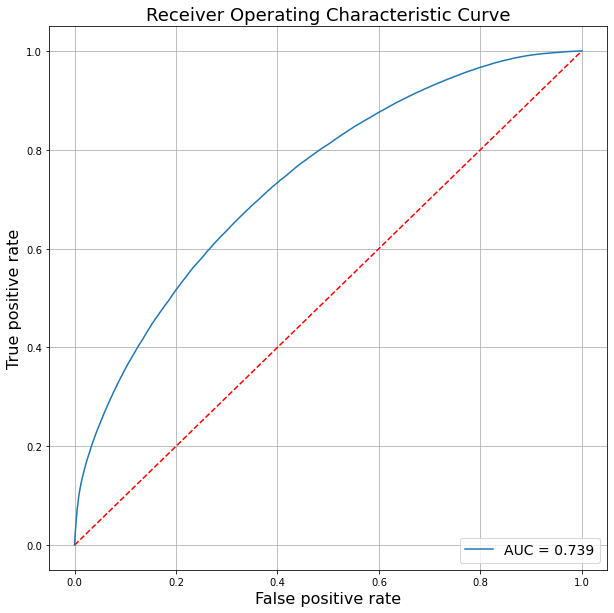

In [9]:
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'r--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('Receiver Operating Characteristic Curve',fontsize=18)
plt.legend(loc="lower right", fontsize = 14)
plt.grid(visible=bool)
plt.savefig('../Figures/DNN_roc_no_date');

In [10]:
Y_PREDICT = torch.argmax(torch.tensor(y_pred), dim=1)

In [11]:
confmat = ConfusionMatrix(num_classes=2)
confmat(Y_PREDICT, y_test)

tensor([[ 25650,  20764],
        [ 47790, 112828]])